In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [3]:
import os
import time
import subprocess
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [5]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/10 17:24:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
filtered.createOrReplaceTempView("filtered")

In [7]:
query = '''
select created_at, coordinates.coordinates as coord,
user.screen_name as Profile,
user.description as descrip,
user.location as loc,
user.verified as user_verified
from filtered'''
a = spark.sql(query)

In [8]:
from pyspark.sql.functions import col, when

b = a.filter(col('user_verified') == True).withColumn("Topic", when(
    (col("descrip").rlike('.*applications.*')), "THESIS"
))


In [9]:
b.createOrReplaceTempView("filtered")

In [10]:
spark.sql("select Profile,Topic,descrip,loc from filtered where Topic = 'THESIS'").toPandas().head(10)

,Profile,Topic,descrip,loc
0,DBTIndia,THESIS,"The Department of Biotechnology, Ministry of S...","New Delhi, India"
1,chooseboundless,THESIS,"10+ years of approvals. 70,000+ successful app...","Seattle, WA"
2,chooseboundless,THESIS,"10+ years of approvals. 70,000+ successful app...","Seattle, WA"
3,Marylandgovjobs,THESIS,Links to the Md Dept of Budget and Management ...,"State of Maryland, USA"
4,dodsbir,THESIS,@DeptofDefense SBIR/STTR programs annually fun...,"Washington, DC"
5,InfluxDB,THESIS,#InfluxDB is the leading time series platform....,San Francisco
6,sheffhallamuni,THESIS,University of the Year 2022 - Educate North Aw...,Sheffield
7,LeahBecerra,THESIS,Editor of mobile applications📱at @BostonGlobe....,Boston
8,LDO_Space,THESIS,Welcome to @Leonardo_live space hub! Providing...,Rome
9,InfluxDB,THESIS,#InfluxDB is the leading time series platform....,San Francisco


In [11]:
P = spark.sql("SELECT Topic, loc, COUNT(*) AS count FROM filtered WHERE Topic = 'THESIS' GROUP BY Topic, loc").toPandas()

In [15]:
P.head()

,Topic,loc,count
0,THESIS,San Francisco,2
1,THESIS,Rome,1
2,THESIS,Boston,1
3,THESIS,"297 Euston Rd, London NW1 3AD",2
4,THESIS,Sheffield,1


In [17]:
!pip install geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 4.8 MB/s eta 0:00:00


In [19]:
%%time
import geocoder
import pandas as pd
import time

# define a function to geocode locations in batches

def geocode_batch(locations):
    # geocode the locations in batches
    batch_size = 100
    results = []
    for i in range(0, len(locations), batch_size):
        batch = locations[i:i+batch_size]
        batch_str = ','.join([''] if x is None else x for x in batch)
        # geocode the batch
        g = geocoder.osm(batch_str, timeout=10)
        if g.ok:
            results.extend(g)
        # sleep to avoid hitting rate limits
        time.sleep(1)
    return results


# define a function to get country from location
def get_country(location, cache):
    # check if the country is in the cache
    if location in cache:
        return cache[location]
    
    # otherwise, geocode the location
    g = geocoder.osm(location, timeout=10)
    if g.ok:
        # cache the result
        cache[location] = g.country
        return g.country
    else:
        return None

# initialize a cache
cache = {}

# extract the locations from the Pandas DataFrame as a list
locations = P['loc'].tolist()

# geocode the locations in batches
results = geocode_batch(locations)

# map the results to a dictionary
location_dict = {}
for result in results:
    if result is not None:
        location_dict[result['query']] = result['country']

# add a new 'country' column to the dataframe
P['country'] = P['loc'].apply(lambda location: get_country(location, cache))

CPU times: user 170 ms, sys: 4.9 ms, total: 175 ms
Wall time: 6.15 s


In [20]:
P

,Topic,loc,count,country
0,THESIS,San Francisco,2,United States
1,THESIS,Rome,1,Italia
2,THESIS,Boston,1,United States
3,THESIS,"297 Euston Rd, London NW1 3AD",2,United Kingdom
4,THESIS,Sheffield,1,United Kingdom
5,THESIS,"New Delhi, India",9,India
6,THESIS,"Washington, DC",4,United States
7,THESIS,"Derby, Derbyshire, UK",4,United Kingdom
8,THESIS,"State of Maryland, USA",6,United States
9,THESIS,"Seattle, WA",3,United States


In [22]:
df1 = P.groupby('country').sum('count').sort_values('count', ascending = False)

In [23]:
df1.reset_index(inplace=True)
df1

,country,count
0,United States,16
1,India,9
2,United Kingdom,7
3,Italia,1


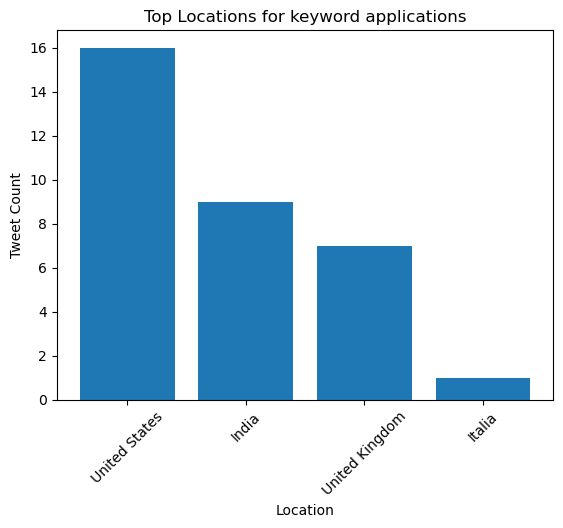

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession

# Create bar graph
plt.bar(df1['country'],df1['count'])
plt.xticks(rotation=45)
plt.title('Top Locations for keyword applications')
plt.xlabel('Location')
plt.ylabel('Tweet Count')
plt.show()

In [25]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 56.4 MB/s eta 0:00:0000:0100:01
